In [1]:
%pylab inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn
import datetime as dt

Populating the interactive namespace from numpy and matplotlib


In [2]:
import yatsm
from yatsm.io import read_pixel_timeseries
from yatsm.utils import csvfile_to_dataframe, get_image_IDs
from yatsm.config_parser import convert_config, parse_config_file
from yatsm.config_parser import convert_config, parse_config_file
import yatsm._cyprep as cyprep

In [43]:
## SPECIFY CONFIG FILE
config_file = '/projectnb/landsat/projects/Massachusetts/p013r031/p013r031_config_pixel.yaml'

# Read in and parse config file
cfg = parse_config_file(config_file)

In [44]:
# Get files list
df = csvfile_to_dataframe(cfg['dataset']['input_file'], \
                          date_format=cfg['dataset']['date_format'])

In [45]:
# SPECIFY disturbance parameters
T_TCB_diff = -0.0500   # change in annual mean TCB
T_TCB_sum = -0.0500    # cumulative difference in annual mean TCB

T_TCG_veg = 0.70    # % reduction in TCG amplitude (relative to TS start)
T_TCG_open = 0.0750    # TCG amplitude threshold for open water conditions


In [46]:
# Run pixel
px = 6248 # column
py = 1634 # row 
change_date = datetime.datetime.strptime('2005 100', '%Y %j')
#change_date = []
#CCDC_date = datetime.datetime.strptime('2000 190', '%Y %j')
CCDC_date = []

# Get dates for image stack
df['image_ID'] = get_image_IDs(df['filename']) 
df['x'] = df['date'] 
dates = df['date'].values

# Read in time series as numpy array
Y = read_pixel_timeseries(df['filename'], px, py)

if np.all(Y[0] == -9999): # skip if TS is all nodata
    pass

else: # process time series for disturbance events

    # Mask based on physical constraints and Fmask 
    valid = cyprep.get_valid_mask( \
                Y, \
                cfg['dataset']['min_values'], \
                cfg['dataset']['max_values']).astype(bool)

    # Apply mask band
    idx_mask = cfg['dataset']['mask_band'] - 1
    valid *= np.in1d(Y.take(idx_mask, axis=0), \
                             cfg['dataset']['mask_values'], \
                             invert=True).astype(np.bool)

    # Mask time series using fmask result
    Y_fmask = np.delete(Y, idx_mask, axis=0)[:, valid]
    dates_fmask = dates[valid]

    # Apply multitemporal mask - original time series (no fmask)
    # Multi-temp only TS used for TCG range - preserves more winter obs
    # Step 1. mask where green > 3 stddev
    multitemp1 = np.where(Y[1] < (np.mean(Y_fmask[1])+np.std(Y_fmask[1])*3))
    dates_multi = dates[multitemp1[0]] 
    Y_multi = Y[:, multitemp1[0]]
    # Step 2. mask where swir < 3 std dev
    multitemp2 = np.where(Y_multi[4] > (np.mean(Y_fmask[4])-np.std(Y_fmask[4])*3))
    dates_multi = dates_multi[multitemp2[0]] 
    Y_multi = Y_multi[:, multitemp2[0]]
    Y_multi = Y_multi.astype(float)/10000

    # Apply multi-temporal mask - fmask time series
    # Fully masked TS used for TCB mean
    # Step 1. mask where green > 3 stddev
    multitemp1_fmask = np.where(Y_fmask[1] < (np.mean(Y_fmask[1])+np.std(Y_fmask[1])*3))
    dates_fmask = dates_fmask[multitemp1_fmask[0]] 
    Y_fmask = Y_fmask[:, multitemp1_fmask[0]]
    # Step 2. mask where swir < 3 std dev
    multitemp2_fmask = np.where(Y_fmask[4] > (np.mean(Y_fmask[4])-np.std(Y_fmask[4])*3))
    dates_fmask = dates_fmask[multitemp2_fmask[0]] 
    Y_fmask = Y_fmask[:, multitemp2_fmask[0]]
    Y_fmask = Y_fmask.astype(float)/10000

    # convert time from ordinal to dates
    dt_dates_multi = np.array([dt.datetime.fromordinal(d) for d in dates_multi])
    dt_dates_fmask = np.array([dt.datetime.fromordinal(d) for d in dates_fmask])

    # Create dataframes for analysis
    # Fmasked + multitemporal masked data (for TCB TS)
    # Step 1. reshape data
    shp_ = dt_dates_fmask.shape[0]
    dt_dates_fmask_csv = dt_dates_fmask.reshape(shp_, 1)
    Y_fmask_csv = np.transpose(Y_fmask)
    data_fmask = np.concatenate([dt_dates_fmask_csv, Y_fmask_csv], axis=1)
    col_names = ['date', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'therm', 'tcb', 'tcg', 'tcw']
    band_names = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'therm', 'tcb', 'tcg', 'tcw']
    # Step 2. create dataframe
    data_fmask_df = pd.DataFrame(data_fmask, columns=col_names)
    # convert reflectance to int
    data_fmask_df[band_names] = data_fmask_df[band_names].astype(float) 
    # Step 3. group by year to generate annual TS
    year_group_fmask = data_fmask_df.groupby(data_fmask_df.date.dt.year)
    # get years in time series 
    years_fmask = np.asarray(year_group_fmask.groups.keys()) 
    years_fmask = years_fmask.astype(int)

    # Multitemporal only masked data (for TCG TS)
    # Step 1. reshape data
    shp_ = dt_dates_multi.shape[0]
    dt_dates_multi_csv = dt_dates_multi.reshape(shp_, 1)
    Y_multi_csv = np.transpose(Y_multi)
    data_multi = np.concatenate([dt_dates_multi_csv, Y_multi_csv], axis=1)
    col_names = ['date', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'therm', 'tcb', 'tcg', 'tcw', 'fmask']
    # Step 2. create dataframe
    data_multi_df = pd.DataFrame(data_multi, columns=col_names)
    # convert reflectance to int
    data_multi_df[band_names] = data_multi_df[band_names].astype(float) # convert reflectance to int
    # Step 3. group by year to generate annual TS
    year_group_multi = data_multi_df.groupby(data_multi_df.date.dt.year) # annual time series
    # get years in time series 
    years_multi = np.asarray(year_group_multi.groups.keys()) # years in time series
    years_multi = years_multi.astype(int)

    # TC Brightness Change Detection - Flood
    # Calculate mean annual TCB
    TCB_mean = year_group_fmask['tcb'].mean()
    # Calculate year-to-year difference in mean TCB
    TCB_mean_diff = np.diff(TCB_mean)
    # Cumulative sum of annual difference in TCB
    TCB_mean_sum = np.cumsum(TCB_mean_diff)

    # TC Greenness Change Detection - Vegetation
    # Find annual min TCG
    TCG_min = year_group_multi['tcg'].min()
    # Find annual max TCG
    TCG_max = year_group_multi['tcg'].max()  
    # Calculate annual range TCG       
    TCG_amp = np.asarray(TCG_max - TCG_min)
    # Normalize to first year's value (assuming forest)
    TCG_amp_adj = TCG_amp.astype(float) / TCG_amp[0].astype(float) 

    # Detect disturbance based on TCB/TCG thresholds
    # Record year of disturbance
    length = (years_fmask.size - 1)
    disturbances = np.zeros(length)
    veg_cond = np.zeros(length)

    for index, year in enumerate(years_fmask): 
        if index < length:
            if (((TCB_mean_diff[index] < T_TCB_diff) and (TCG_amp_adj[index+1] < T_TCG_veg)) or \
                 ((TCB_mean_sum[index] < T_TCB_sum) and (TCG_amp_adj[index+1] < T_TCG_veg))):
                disturbances[index] = year+1
                #print('{row}, {col} - {year}'.format(row=py, col=px, year=year))
            else:
                continue
    # Record vegetation condition 
    #(IN TESTING - NOT WORKING RIGHT YET!)            
    #for index, year in enumerate(years_fmask):
    #    if index < length:
    #        if (TCG_amp[index] < T_TCG_open): 
    #            veg_cond[py, px, index] = 1
    #        elif (TCG_amp_adj[index] < T_TCG_veg):   
    #            veg_cond[py, px, index] = 2
    #        else:
    #            veg_cond[py, px, index] = 3
    #    else:
    #        continue          
print('Analysis of disturbance complete!')



Analysis of disturbance complete!


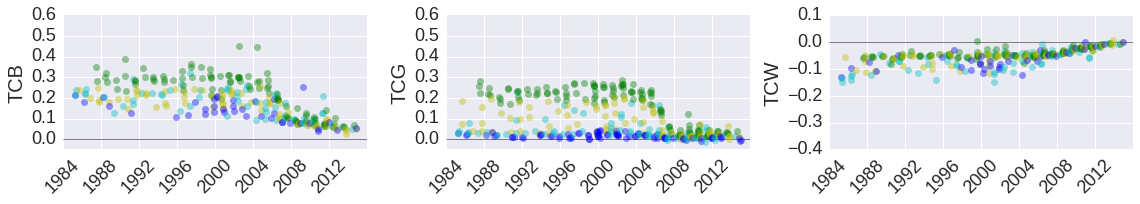

In [ ]:
# Time series plots (no interpretation)
fig = plt.figure(figsize=(16,3),facecolor='w', edgecolor='k')
xmin = datetime.datetime.strptime('1984 1', '%Y %j')
xmax = datetime.datetime.strptime('2015 365', '%Y %j')

ax = fig.add_subplot(131)
#plt.xlim((date1, date2))
plt.axhline(0, lw=0.5, color='k', ls='-') # add y=0 reference line  


for date in dt_dates_fmask:
    if date.month == 11 or date.month == 12 or date.month == 1 or date.month == 2 or date.month == 3:
        plt.plot(date, Y_fmask[7, np.where(dt_dates_fmask==date)],'bo', alpha=0.4)
    elif date.month == 4 or date.month == 5:
        plt.plot(date, Y_fmask[7, np.where(dt_dates_fmask==date)],'co', alpha=0.4)
    elif date.month == 6 or date.month == 7 or date.month == 8:
        plt.plot(date, Y_fmask[7, np.where(dt_dates_fmask==date)],'go', alpha=0.4)
    else:
        plt.plot(date, Y_fmask[7, np.where(dt_dates_fmask==date)],'yo', alpha=0.4)
#plt.axvline(change_date, color='k', ls='--', lw='1.5') # add change date line

plt.yticks(fontsize=18)
plt.xticks(fontsize=18, rotation=45)    
plt.ylabel('TCB', fontsize=20)
plt.ylim((-0.05, 0.60))     
plt.xlim((xmin, xmax))
    
ax = fig.add_subplot(132)
#plt.xlim((date1, date2))
plt.axhline(0, lw=0.5, color='k', ls='-') # add y=0 reference line   


for date in dt_dates_multi:
    if date.month == 11 or date.month == 12 or date.month == 1 or date.month == 2 or date.month == 3:
        plt.plot(date, Y_multi[8, np.where(dt_dates_multi==date)],'bo', alpha=0.4)
    elif date.month == 4 or date.month == 5:
        plt.plot(date, Y_multi[8, np.where(dt_dates_multi==date)],'co', alpha=0.4)
    elif date.month == 6 or date.month == 7 or date.month == 8:
        plt.plot(date, Y_multi[8, np.where(dt_dates_multi==date)],'go', alpha=0.4)
    else:
        plt.plot(date, Y_multi[8, np.where(dt_dates_multi==date)],'yo', alpha=0.4)
#plt.axvline(change_date, color='k', ls='--', lw='1.5') # add change date line

plt.ylabel('TCG', fontsize=20)
plt.ylim((-0.0500, 0.6000))
plt.yticks(fontsize=18)
plt.xticks(fontsize=18, rotation=45)   
plt.xlim((xmin, xmax))

ax = fig.add_subplot(133)
#plt.xlim((date1, date2))
plt.axhline(0, lw=0.5, color='k', ls='-') # add y=0 reference line  


for date in dt_dates_fmask:
    if date.month == 11 or date.month == 12 or date.month == 1 or date.month == 2 or date.month == 3:
        plt.plot(date, Y_fmask[9, np.where(dt_dates_fmask==date)],'bo', alpha=0.4)
    elif date.month == 4 or date.month == 5:
        plt.plot(date, Y_fmask[9, np.where(dt_dates_fmask==date)],'co', alpha=0.4)
    elif date.month == 6 or date.month == 7 or date.month == 8:
        plt.plot(date, Y_fmask[9, np.where(dt_dates_fmask==date)],'go', alpha=0.4)
    else:
        plt.plot(date, Y_fmask[9, np.where(dt_dates_fmask==date)],'yo', alpha=0.4)
#plt.axvline(change_date, color='k', ls='--', lw='1.5') # add change date line

plt.ylabel('TCW', fontsize=20)
plt.ylim((-0.4000, 0.1000))
plt.yticks(fontsize=18)
plt.xticks(fontsize=18, rotation=45)   
plt.xlim((xmin, xmax))

#winter = mlines.Line2D([], [], linewidth=0, color='b', marker='o',
#                          markersize=4, label='Nov - Mar', alpha=0.8)
#spring = mlines.Line2D([], [], linewidth=0, color='c', marker='o',
#                          markersize=4, label='Apr / May', alpha=0.8)
#summer = mlines.Line2D([], [], linewidth=0, color='g', marker='o',
#                          markersize=4, label='Jun - Aug', alpha=0.8)
#fall = mlines.Line2D([], [], linewidth=0, color='y', marker='o',
##                          markersize=4, label='Sep / Oct', alpha=0.8)
#plt.legend(handles=[winter, spring, summer, fall], fontsize=16)#

fig.tight_layout()
plt.savefig('./paper_figures/{y}_{x}_trajectory.png'.format(x=px, y=py))


In [ ]:
# Time series plots (with change date)
fig = plt.figure(figsize=(16,3),facecolor='w', edgecolor='k')
xmin = datetime.datetime.strptime('1984 1', '%Y %j')
xmax = datetime.datetime.strptime('2015 365', '%Y %j')

ax = fig.add_subplot(131)
#plt.xlim((date1, date2))
plt.axhline(0, lw=0.5, color='k', ls='-') # add y=0 reference line  


for date in dt_dates_fmask:
    if date.month == 11 or date.month == 12 or date.month == 1 or date.month == 2 or date.month == 3:
        plt.plot(date, Y_fmask[7, np.where(dt_dates_fmask==date)],'bo', alpha=0.4)
    elif date.month == 4 or date.month == 5:
        plt.plot(date, Y_fmask[7, np.where(dt_dates_fmask==date)],'co', alpha=0.4)
    elif date.month == 6 or date.month == 7 or date.month == 8:
        plt.plot(date, Y_fmask[7, np.where(dt_dates_fmask==date)],'go', alpha=0.4)
    else:
        plt.plot(date, Y_fmask[7, np.where(dt_dates_fmask==date)],'yo', alpha=0.4)

plt.axvline(change_date, color='k', ls='--', lw='1.5') # add change date line

plt.yticks(fontsize=18)
plt.xticks(fontsize=18, rotation=45)    
plt.ylabel('TCB', fontsize=20)
plt.ylim((-0.0500, 0.6000))     
plt.xlim((xmin, xmax))
    
ax = fig.add_subplot(132)
#plt.xlim((date1, date2))
plt.axhline(0, lw=0.5, color='k', ls='-') # add y=0 reference line   


for date in dt_dates_multi:
    if date.month == 11 or date.month == 12 or date.month == 1 or date.month == 2 or date.month == 3:
        plt.plot(date, Y_multi[8, np.where(dt_dates_multi==date)],'bo', alpha=0.4)
    elif date.month == 4 or date.month == 5:
        plt.plot(date, Y_multi[8, np.where(dt_dates_multi==date)],'co', alpha=0.4)
    elif date.month == 6 or date.month == 7 or date.month == 8:
        plt.plot(date, Y_multi[8, np.where(dt_dates_multi==date)],'go', alpha=0.4)
    else:
        plt.plot(date, Y_multi[8, np.where(dt_dates_multi==date)],'yo', alpha=0.4)
plt.axvline(change_date, color='k', ls='--', lw='1.5') # add change date line

plt.ylabel('TCG', fontsize=20)
plt.ylim((-0.0500, 0.6000))
plt.yticks(fontsize=18)
plt.xticks(fontsize=18, rotation=45)   
plt.xlim((xmin, xmax))

ax = fig.add_subplot(133)
#plt.xlim((date1, date2))
plt.axhline(0, lw=0.5, color='k', ls='-') # add y=0 reference line  


for date in dt_dates_fmask:
    if date.month == 11 or date.month == 12 or date.month == 1 or date.month == 2 or date.month == 3:
        plt.plot(date, Y_fmask[9, np.where(dt_dates_fmask==date)],'bo', alpha=0.4)
    elif date.month == 4 or date.month == 5:
        plt.plot(date, Y_fmask[9, np.where(dt_dates_fmask==date)],'co', alpha=0.4)
    elif date.month == 6 or date.month == 7 or date.month == 8:
        plt.plot(date, Y_fmask[9, np.where(dt_dates_fmask==date)],'go', alpha=0.4)
    else:
        plt.plot(date, Y_fmask[9, np.where(dt_dates_fmask==date)],'yo', alpha=0.4)
plt.axvline(change_date, color='k', ls='--', lw='1.5') # add change date line

plt.ylabel('TCW', fontsize=20)
plt.ylim((-0.4000, 0.1000))
plt.yticks(fontsize=18)
plt.xticks(fontsize=18, rotation=45)   
plt.xlim((xmin, xmax))

#winter = mlines.Line2D([], [], linewidth=0, color='b', marker='o',
#                          markersize=4, label='Nov - Mar', alpha=0.8)
#spring = mlines.Line2D([], [], linewidth=0, color='c', marker='o',
#                          markersize=4, label='Apr / May', alpha=0.8)
#summer = mlines.Line2D([], [], linewidth=0, color='g', marker='o',
#                          markersize=4, label='Jun - Aug', alpha=0.8)
#fall = mlines.Line2D([], [], linewidth=0, color='y', marker='o',
##                          markersize=4, label='Sep / Oct', alpha=0.8)
#plt.legend(handles=[winter, spring, summer, fall], fontsize=16)#

fig.tight_layout()
plt.savefig('./paper_figures/{y}_{x}_trajectory_withdate.png'.format(x=px, y=py))

In [ ]:
# Time series plots
fig = plt.figure(figsize=(9,11),facecolor='w', edgecolor='k')

ax = fig.add_subplot(311)
#plt.xlim((date1, date2))
plt.axhline(0, lw=0.5, color='k', ls='-') # add y=0 reference line  

#plt.axvline(change_date, color='k', ls='--', lw='1.5') # add change date line
disturbed = np.unique(disturbances).astype(int)
for disturbance in disturbed:
    if disturbance > 0:
        plt.axvline(dt.date(disturbance,1,1), color='r', alpha=0.5)
        date_plt = ax.plot(dt.date(disturbance,1,1), -500, 'ro')

for date in dt_dates_fmask:
    if date.month == 11 or date.month == 12 or date.month == 1 or date.month == 2 or date.month == 3:
        plt.plot(date, Y_fmask[7, np.where(dt_dates_fmask==date)],'bo', alpha=0.4)
    elif date.month == 4 or date.month == 5:
        plt.plot(date, Y_fmask[7, np.where(dt_dates_fmask==date)],'co', alpha=0.4)
    elif date.month == 6 or date.month == 7 or date.month == 8:
        plt.plot(date, Y_fmask[7, np.where(dt_dates_fmask==date)],'go', alpha=0.4)
    else:
        plt.plot(date, Y_fmask[7, np.where(dt_dates_fmask==date)],'yo', alpha=0.4)
        
TCB_mean_arr = np.asarray(TCB_mean)
for index, tcb in enumerate(TCB_mean):
    date = dt.date(year_group_fmask.groups.keys()[index], 1, 1)
    plt.plot(date, tcb, 'ko')
    
plt_mean = mlines.Line2D([], [], linewidth=0, color='k', marker='o',
                          markersize=5, label='mean')
plt.legend(handles=[plt_mean], fontsize=16, loc='best')

plt.yticks(fontsize=20)
plt.xticks(fontsize=20, rotation=45)    
plt.ylabel('TCB', fontsize=20, color='b')
plt.ylim((-0.0500, 0.6000))
plt.xlim((xmin, xmax))
    
ax = fig.add_subplot(312)
#plt.xlim((date1, date2))
plt.axhline(0, lw=0.5, color='k', ls='-') # add y=0 reference line  

#plt.axvline(change_date, color='k', ls='--', lw='1.5') # add change date line
disturbed = np.unique(disturbances).astype(int)
for disturbance in disturbed:
    if disturbance > 0:
        plt.axvline(dt.date(disturbance,1,1), color='r', alpha=0.5, label='F')
        date_plt = ax.plot(dt.date(disturbance,1,1), -0.0500, 'ro')
        #plt.annotate('F', xy=(dt.date(disturbance,1,1), -450), xycoords='data', 
        #             xytext=((dt.date(disturbance,1,1), -450)),textcoords='data')

for date in dt_dates_multi:
    if date.month == 11 or date.month == 12 or date.month == 1 or date.month == 2 or date.month == 3:
        plt.plot(date, Y_multi[8, np.where(dt_dates_multi==date)],'bo', alpha=0.4)
    elif date.month == 4 or date.month == 5:
        plt.plot(date, Y_multi[8, np.where(dt_dates_multi==date)],'co', alpha=0.4)
    elif date.month == 6 or date.month == 7 or date.month == 8:
        plt.plot(date, Y_multi[8, np.where(dt_dates_multi==date)],'go', alpha=0.4)
    else:
        plt.plot(date, Y_multi[8, np.where(dt_dates_multi==date)],'yo', alpha=0.4)
        
TCG_max_arr = np.asarray(TCG_max)
for index, tcg_max in enumerate(TCG_max):
    date = dt.date(year_group_fmask.groups.keys()[index], 1, 1)
    plt.plot(date, tcg_max, marker='v', color='k', markersize=9)

TCG_min_arr = np.asarray(TCG_min)
for index, tcg_min in enumerate(TCG_min):
    date = dt.date(year_group_fmask.groups.keys()[index], 1, 1)
    plt.plot(date, tcg_min, marker='^', color='k', markersize=9)
plt.ylabel('TCG', fontsize=20, color='g')
plt.ylim((-0.0500, 0.6000))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20, rotation=45)  
plt.xlim((xmin, xmax))

plt_max = mlines.Line2D([], [], linewidth=0, color='k', marker='v',
                          markersize=7, label='max')
plt_min = mlines.Line2D([], [], linewidth=0, color='k', marker='^',
                          markersize=7, label='min')
plt.legend(handles=[plt_max, plt_min], fontsize=16, loc='best')

ax = fig.add_subplot(325, aspect='auto')
ax.add_patch(
    mpatches.Rectangle(
        (0, -0.4000),   # (x,y)
        T_TCG_veg*TCG_amp[0],          # width
        0.3500,          # height
        alpha=0.3)
    )

colors_ = plt.cm.plasma(np.linspace(0,1,len(years_fmask)))
plt.scatter(TCG_amp[1:30], TCB_mean_diff, c=colors_, cmap='plasma', edgecolors='none', s=40)

plt.axvline(T_TCG_veg*TCG_amp[0], lw=1.5, color='g', ls='--')
#plt.axvline(T_TCG_open, lw=1, color='b', ls='--')
plt.axhline(T_TCB_diff, lw=1.5, color='b', ls='--')
plt.axhline(0, lw=0.5, color='k', ls='-')
plt.ylabel('$\Delta$ TCB', fontsize=20, color='b')
plt.xlabel('range TCG', fontsize=20, color='g')
plt.ylim((-0.4000, 0.2000))
plt.xlim((0, 0.4000))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20, rotation=90)  


ax = fig.add_subplot(326, aspect='auto')
ax.add_patch(
    mpatches.Rectangle(
        (0, -0.4000),   # (x,y)
        T_TCG_veg*TCG_amp[0],          # width
        0.3500,          # height
    alpha=0.3)
)

cusum = plt.scatter(TCG_amp[1:30], TCB_mean_sum, c=colors_, edgecolors='none', s=40)
m = plt.cm.ScalarMappable(cmap=plt.cm.plasma)
m.set_array(years_fmask)
cbar = plt.colorbar(m, fraction=0.046, pad=0.03)
cbar.ax.tick_params(labelsize=16) 


plt.axvline(T_TCG_veg*TCG_amp[0], lw=1.5, color='g', ls='--')
#plt.axvline(T_TCG_open, lw=1, color='b', ls='--')
plt.axhline(T_TCB_diff, lw=1.5, color='b', ls='--')
plt.axhline(0, lw=0.5, color='k', ls='-')
plt.ylabel(r'cusum($\Delta$ TCB)', fontsize=20, color='b')
plt.xlabel('range TCG', fontsize=20, color='g')
plt.ylim((-0.4000, 0.2000))
plt.xlim((0, 0.4000))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20, rotation=90) 

fig.tight_layout()
plt.savefig('./paper_figures/{y}_{x}_TCB-TCG-panel.png'.format(x=px, y=py))



In [ ]:
# Time series plots (with interpreted date)
fig = plt.figure(figsize=(9,11),facecolor='w', edgecolor='k')

ax = fig.add_subplot(311)
#plt.xlim((date1, date2))
plt.axhline(0, lw=0.5, color='k', ls='-') # add y=0 reference line  

plt.axvline(change_date, color='k', ls='--', lw='1.5') # add change date line
#plt.axvline(CCDC_date, color='k', ls='-', lw='1.5') # add CCDC date line

disturbed = np.unique(disturbances).astype(int)
for disturbance in disturbed:
    if disturbance > 0:
        plt.axvline(dt.date(disturbance,1,1), color='r', alpha=0.5)
        date_plt = ax.plot(dt.date(disturbance,1,1), -500, 'ro')

for date in dt_dates_fmask:
    if date.month == 11 or date.month == 12 or date.month == 1 or date.month == 2 or date.month == 3:
        plt.plot(date, Y_fmask[7, np.where(dt_dates_fmask==date)],'bo', alpha=0.4)
    elif date.month == 4 or date.month == 5:
        plt.plot(date, Y_fmask[7, np.where(dt_dates_fmask==date)],'co', alpha=0.4)
    elif date.month == 6 or date.month == 7 or date.month == 8:
        plt.plot(date, Y_fmask[7, np.where(dt_dates_fmask==date)],'go', alpha=0.4)
    else:
        plt.plot(date, Y_fmask[7, np.where(dt_dates_fmask==date)],'yo', alpha=0.4)
        
TCB_mean_arr = np.asarray(TCB_mean)
for index, tcb in enumerate(TCB_mean):
    date = dt.date(year_group_fmask.groups.keys()[index], 1, 1)
    plt.plot(date, tcb, 'ko')
    
plt_mean = mlines.Line2D([], [], linewidth=0, color='k', marker='o',
                          markersize=5, label='mean')
plt.legend(handles=[plt_mean], fontsize=16, loc='best')

plt.yticks(fontsize=20)
plt.xticks(fontsize=20, rotation=45)    
plt.ylabel('TCB', fontsize=20, color='b')
plt.ylim((-0.0500, 0.6000))
plt.xlim((xmin, xmax))
    
ax = fig.add_subplot(312)
#plt.xlim((date1, date2))
plt.axhline(0, lw=0.5, color='k', ls='-') # add y=0 reference line  

plt.axvline(change_date, color='k', ls='--', lw='1.5') # add change date line
#plt.axvline(CCDC_date, color='k', ls='-', lw='1.5') # add CCDC date line

disturbed = np.unique(disturbances).astype(int)
for disturbance in disturbed:
    if disturbance > 0:
        plt.axvline(dt.date(disturbance,1,1), color='r', alpha=0.5, label='F')
        date_plt = ax.plot(dt.date(disturbance,1,1), -0.0500, 'ro')
        #plt.annotate('F', xy=(dt.date(disturbance,1,1), -450), xycoords='data', 
        #             xytext=((dt.date(disturbance,1,1), -450)),textcoords='data')

for date in dt_dates_multi:
    if date.month == 11 or date.month == 12 or date.month == 1 or date.month == 2 or date.month == 3:
        plt.plot(date, Y_multi[8, np.where(dt_dates_multi==date)],'bo', alpha=0.4)
    elif date.month == 4 or date.month == 5:
        plt.plot(date, Y_multi[8, np.where(dt_dates_multi==date)],'co', alpha=0.4)
    elif date.month == 6 or date.month == 7 or date.month == 8:
        plt.plot(date, Y_multi[8, np.where(dt_dates_multi==date)],'go', alpha=0.4)
    else:
        plt.plot(date, Y_multi[8, np.where(dt_dates_multi==date)],'yo', alpha=0.4)
        
TCG_max_arr = np.asarray(TCG_max)
for index, tcg_max in enumerate(TCG_max):
    date = dt.date(year_group_fmask.groups.keys()[index], 1, 1)
    plt.plot(date, tcg_max, marker='v', color='k', markersize=9)

TCG_min_arr = np.asarray(TCG_min)
for index, tcg_min in enumerate(TCG_min):
    date = dt.date(year_group_fmask.groups.keys()[index], 1, 1)
    plt.plot(date, tcg_min, marker='^', color='k', markersize=9)
plt.ylabel('TCG', fontsize=20, color='g')
plt.ylim((-0.0500, 0.6000))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20, rotation=45)  
plt.xlim((xmin, xmax))

plt_max = mlines.Line2D([], [], linewidth=0, color='k', marker='v',
                          markersize=7, label='max')
plt_min = mlines.Line2D([], [], linewidth=0, color='k', marker='^',
                          markersize=7, label='min')
plt.legend(handles=[plt_max, plt_min], fontsize=16, loc='best')

ax = fig.add_subplot(325, aspect='auto')
ax.add_patch(
    mpatches.Rectangle(
        (0, -0.4000),   # (x,y)
        T_TCG_veg*TCG_amp[0],          # width
        0.3500,          # height
        alpha=0.3)
    )

colors_ = plt.cm.plasma(np.linspace(0,1,len(years_fmask)))
plt.scatter(TCG_amp[1:30], TCB_mean_diff, c=colors_, cmap='plasma', edgecolors='none', s=40)

plt.axvline(T_TCG_veg*TCG_amp[0], lw=1.5, color='g', ls='--')
#plt.axvline(T_TCG_open, lw=1, color='b', ls='--')
plt.axhline(T_TCB_diff, lw=1.5, color='b', ls='--')
plt.axhline(0, lw=0.5, color='k', ls='-')
plt.ylabel('$\Delta$ TCB', fontsize=20, color='b')
plt.xlabel('range TCG', fontsize=20, color='g')
plt.ylim((-0.4000, 0.2000))
plt.xlim((0, 0.4000))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20, rotation=90)  


ax = fig.add_subplot(326, aspect='auto')
ax.add_patch(
    mpatches.Rectangle(
        (0, -0.4000),   # (x,y)
        T_TCG_veg*TCG_amp[0],          # width
        0.3500,          # height
    alpha=0.3)
)

cusum = plt.scatter(TCG_amp[1:30], TCB_mean_sum, c=colors_, edgecolors='none', s=40)
m = plt.cm.ScalarMappable(cmap=plt.cm.plasma)
m.set_array(years_fmask)
cbar = plt.colorbar(m, fraction=0.046, pad=0.03)
cbar.ax.tick_params(labelsize=16) 


plt.axvline(T_TCG_veg*TCG_amp[0], lw=1.5, color='g', ls='--')
#plt.axvline(T_TCG_open, lw=1, color='b', ls='--')
plt.axhline(T_TCB_diff, lw=1.5, color='b', ls='--')
plt.axhline(0, lw=0.5, color='k', ls='-')
plt.ylabel(r'cusum($\Delta$ TCB)', fontsize=20, color='b')
plt.xlabel('range TCG', fontsize=20, color='g')
plt.ylim((-0.4000, 0.2000))
plt.xlim((0, 0.4000))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20, rotation=90)

fig.tight_layout()
plt.savefig('./paper_figures/{y}_{x}_TCB-TCG-panel_withdate.png'.format(x=px, y=py))